In [1]:
#imports
import os
import json
import pandas as pd
from utils import list_folders, json_to_dataframe, list_all_files, add_districts, district_avg_position_by_capacity, district_avg_position

main_folder = 'snapshots'
dates = list_folders(main_folder)
files = list_all_files(main_folder, dates)

#stations_data = json_to_polar_dataframe(files)
stations_data = json_to_dataframe(files)
# Extact the columns timestamp, station_id, num_bikes_available
stations_master_file = main_folder+ '/2024_05_Maig_BicingNou_INFORMACIO.csv'

stations_master = pd.read_csv(stations_master_file).sort_values(by='station_id')
stations_master['last_updated'] = pd.to_datetime(stations_master['last_updated'])
stations_master = stations_master.sort_values('last_updated').groupby('station_id').last()

/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_32598/2196317456.py:16: DtypeWarning: Columns (9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  stations_master = pd.read_csv(stations_master_file).sort_values(by='station_id')


In [ ]:
stations_master.to_csv('stations_master.csv')

In [91]:
stations_data_filtered = stations_data[['timestamp_file', 'station_id', 'num_bikes_available']].sort_values(by=['station_id','timestamp_file'])

# station_id = 518
stations_data_filtered = stations_data_filtered[stations_data_filtered['station_id'] == '13']
stations_data_filtered['diff'] = stations_data_filtered.groupby('station_id')['num_bikes_available'].diff().fillna(0)
stations_data_filtered['in_bikes'] = stations_data_filtered['diff'].apply(lambda x: x if x > 0 else 0)
stations_data_filtered['out_bikes'] = stations_data_filtered['diff'].apply(lambda x: -x if x < 0 else 0)
stations_data_filtered.drop('diff', axis=1, inplace=True)

/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_91126/1054803763.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  flow_agg['timestamp_file'] = pd.to_datetime(flow_agg['timestamp_file'], unit='s')


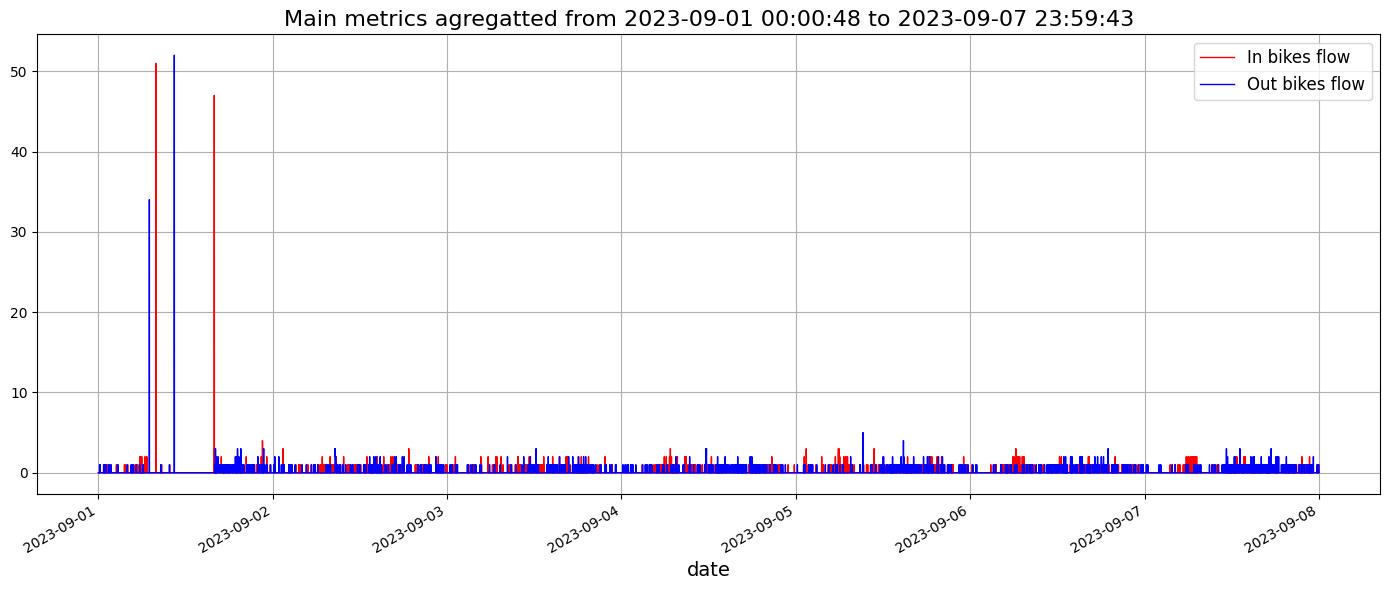

In [92]:
flow_agg = stations_data_filtered.groupby('timestamp_file')[['in_bikes', 'out_bikes']].sum().reset_index()
flow_agg['timestamp_file'] = pd.to_datetime(flow_agg['timestamp_file'], unit='s')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter

# 1 septiembre 2023 -> viernes
plt.figure(figsize=(14, 6))

plt.plot(flow_agg['timestamp_file'], flow_agg['in_bikes'], label='In bikes flow', color='red', linewidth=1)
plt.plot(flow_agg['timestamp_file'], flow_agg['out_bikes'], label='Out bikes flow', color='blue', linewidth=1)

plt.title('Main metrics agregatted from ' + str(flow_agg['timestamp_file'].min()) + ' to ' + str(flow_agg['timestamp_file'].max()), fontsize=16)
plt.xlabel('date', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [93]:
import pandas as pd


stations_master['short_name'] = stations_master['short_name'].astype(int).astype(str)
stations = stations_master['short_name'].to_list()
coordinates = stations_master[['short_name', 'lat', 'lon']]

stations_data['station_id'] = stations_data['station_id'].astype(str)
stations_data['timestamp_file'] = pd.to_datetime(stations_data['timestamp_file'], unit='s')
stations_data['day'] = stations_data['timestamp_file'].dt.date
stations_data.sort_values(by=['station_id', 'timestamp_file'], inplace=True)


stations_data['diff'] = stations_data.groupby('station_id')['num_bikes_available'].diff().fillna(0)
stations_data['in_bikes'] = stations_data['diff'].apply(lambda x: x if x > 0 else 0)

filtered_data_list = []
for name, group in stations_data.groupby('day'):
    max_in_bikes = group.groupby('station_id')['in_bikes'].transform('max')
    filtered_group = group[(group['in_bikes'] == max_in_bikes) & (group['in_bikes'] >= 5)]
    filtered_data_list.append(filtered_group)

recharge = pd.concat(filtered_data_list, axis=0)

# Final cleanup of columns
recharge.drop(['num_bikes_available', 'day', 'diff'], axis=1, inplace=True)
recharge.rename(columns={'station_id': 'short_name'}, inplace=True)
recharge = recharge.merge(coordinates, on='short_name', how='left')
recharge = recharge[['short_name', 'in_bikes', 'timestamp_file', 'lat', 'lon']]


/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_91126/1382631771.py:9: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  stations_data['timestamp_file'] = pd.to_datetime(stations_data['timestamp_file'], unit='s')


In [94]:
stations = stations_master['short_name'].astype(int).astype(str).to_list()
coordinates = stations_master[['short_name', 'lat', 'lon']]
coordinates['short_name'] = coordinates['short_name'].astype(int).astype(str)
stations_data = stations_data[['timestamp_file', 'station_id', 'num_bikes_available']].sort_values(by=['station_id','timestamp_file'])

stations_data['timestamp_file'] = pd.to_datetime(stations_data['timestamp_file'], unit='s')
stations_data['day'] = stations_data['timestamp_file'].dt.date

recharge = pd.DataFrame()

for station in stations:
    stations_data_filtered = stations_data[stations_data['station_id'] == station]
    stations_data_filtered['diff'] = stations_data_filtered.groupby('station_id')['num_bikes_available'].diff().fillna(0)
    stations_data_filtered['in_bikes'] = stations_data_filtered['diff'].apply(lambda x: x if x > 0 else 0)
    stations_data_filtered = stations_data_filtered[(stations_data_filtered['in_bikes'] == stations_data_filtered.groupby('day')['in_bikes'].transform('max')) & (stations_data_filtered['in_bikes'] > 5)]
    # apend to recharge
    recharge = pd.concat([recharge, stations_data_filtered], axis=0)

# drop num_bikes_available, day, diff
recharge.drop(['num_bikes_available', 'day', 'diff'], axis=1, inplace=True)
recharge.rename(columns={'station_id': 'short_name'}, inplace=True)
recharge = recharge.merge(coordinates, on='short_name', how='left')

/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_91126/3591008386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinates['short_name'] = coordinates['short_name'].astype(int).astype(str)
/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_91126/3591008386.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_data_filtered['diff'] = stations_data_filtered.groupby('station_id')['num_bikes_available'].diff().fillna(0)
/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_

In [95]:
recharge.head()

,timestamp_file,short_name,in_bikes,lat,lon
0,2023-09-04 11:30:58,1,6.0,41.397978,2.180107
1,2023-09-02 10:33:51,2,6.0,41.395488,2.177198
2,2023-09-04 17:54:00,2,6.0,41.395488,2.177198
3,2023-09-05 16:41:37,2,6.0,41.395488,2.177198
4,2023-09-06 10:13:37,2,6.0,41.395488,2.177198


In [96]:
# Bike stations by post code
import folium
from folium.plugins import TimestampedGeoJson
import random

available_colors = [
    'lightgreen', 'pink', 'beige', 'gray', 'green', 'cadetblue', 'blue', 
    'black', 'lightred', 'darkblue', 'lightblue', 'darkred', 'lightgray', 
    'orange', 'darkgreen', 'red', 'white', 'darkpurple', 'purple'
]



center_coords = [41.41, 2.2]
recharge_map = folium.Map(location=center_coords, zoom_start=12)


data_geojson = {
    'type': 'FeatureCollection',
    'features': [
        {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['lon'], row['lat']],
            },
            'properties': {
                'time': row['timestamp_file'].strftime('%Y-%m-%dT%H:%M:%SZ'),
                'id': row['short_name'],
                'icon': 'bycicle',
                 }
        } for idx, row in recharge.iterrows()
    ]
}


TimestampedGeoJson(
    data_geojson,
    period='PT5M',
    duration='PT1M',
    auto_play=True,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY/MM/DD HH:mm:ss',
    time_slider_drag_update=True
).add_to(recharge_map)



In [98]:
recharge_map